# NATURAL LANGUAGE PROCESSING AND TEXT CLASSIFICATION

# LEARNING OBJECTIVES

- Define natural language processing
- Get a sense of common tasks associated with NLP
  - use-cases
  - tokenization
  - tagging
  - parsing
- Demonstrate how to classify text or documents using scikit-learn

# DO WORK

When you come to class ...

- Install the Python package spacy with
  - pip install spacy
    
- Run the spacy download model command (~500 MB download)
  - python -m spacy.en.download --force all

# REVIEW:  DECISION TREES AND RANDOM FORESTS
- What are decision trees?
- What are random forests?


ANSWER:

Decision trees are models that ask a series of questions. The next question depends upon the answer to the previous question. Like the game 20 questions.
- Decision trees are weak learners that are easy to overfit.

Random forest models are ensembles of decision trees that are randomized in the way they are created.
- Random forests are strong models that are made up of a collection of decision trees.

Both are: 
- non-linear (as opposed to logistic regression)
- used for either classification or regression


# INTRODUCTION TO DATA FOR TODAY

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

### Load Dataset and Pre-Process

We will continue to use the [Kaggle StumbleUpon Evergreen Classification Challenge](https://www.kaggle.com/c/stumbleupon) for this exercise.

This dataset comes from [StumbleUpon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

In [2]:
# Load data
data = pd.read_csv("assets/dataset/stumbleupon.tsv", sep='\t')

# Split `boilerplate` column
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 29 columns):
url                               7395 non-null object
urlid                             7395 non-null int64
boilerplate                       7395 non-null object
alchemy_category                  7395 non-null object
alchemy_category_score            7395 non-null object
avglinksize                       7395 non-null float64
commonlinkratio_1                 7395 non-null float64
commonlinkratio_2                 7395 non-null float64
commonlinkratio_3                 7395 non-null float64
commonlinkratio_4                 7395 non-null float64
compression_ratio                 7395 non-null float64
embed_ratio                       7395 non-null float64
framebased                        7395 non-null int64
frameTagRatio                     7395 non-null float64
hasDomainLink                     7395 non-null int64
html_ratio                        7395 non-null float64
image_r

In [3]:
# Drop missing values
data = data.dropna()

### KNOWLEDGE CHECK
Which features do you think we can use with Natural Language Processing and Text Classification?

ANSWER:
Any kind of string which shows up as an object dtype.

Good candidates are
- title
- body
- url

# INTRODUCTION: NATURAL LANGUAGE PROCESSING
Objective: Define natural language processing

**What is Natural Language Processing (NLP)?**
- Natural language processing is the task of extracting meaning and information from text documents.
- These tasks may range from simple classification tasks, such as deciding what category a piece of text falls into, to more complex tasks like translating or summarizing text.
- For most tasks, a fair amount of pre-processing is required to make the text digestible for our algorithms.  We typically need to add structure to our unstructured data.


**Examples of NLP**
- Many AI assistant systems are typically powered by fairly advanced NLP engines.
  - A system like Siri uses voice-to-transcription to record a command and then various NLP algorithms to identify the question asked and possible answers.
- E-mail spam classification
  - Google e-mail
- Article summarizers/Abstract generators
  - Reddit bots
- Sentiment Analysis
  - Many start-ups in the last few years that focus on Social Media Analysis
- Classification based on Text
  - Alchemy API -- selecting website category based on content

### KNOWLEDGE CHECK

Can we use NLP and text classification for automatically completing search terms?

ANSWER:
Sure! We have text and input and need to give text as output. However, as is the case in many text problems more classical ideas from computer science tend to work better such as inverted index search and regular expressions.

# DEMO: NATURAL LANGUAGE PROCESSING WITH ‘SPACY’
Objective: Get a sense of common tasks associated with NLP

## Part 1: Using spacy

In [4]:
# Import spaCy 
from spacy.en import English
nlp = English()

In [5]:
# Get a title to parse
title = data['title'].values[0]
print title
print type(title)

IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries
<type 'unicode'>


In [6]:
# Parse title using spacy
parsed = nlp(title)
parsed

IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries

This toolkit has 3 pre-processing engines:

- a tokenizer: to identify the word tokens
- a tagger: to identify the concepts described by the words
- a parser: to identify the phrases and links between the different words


In [7]:
help(nlp.tagger)

Help on Tagger object:

class Tagger(__builtin__.object)
 |  A part-of-speech tagger for English
 |  
 |  Methods defined here:
 |  
 |  __call__(...)
 |      Apply the tagger, setting the POS tags onto the Doc object.
 |      
 |      Args:
 |          tokens (Doc): The tokens to be tagged.
 |  
 |  __init__(...)
 |      x.__init__(...) initializes x; see help(type(x)) for signature
 |  
 |  __reduce__(...)
 |  
 |  blank(...)
 |  
 |  default_templates(...)
 |  
 |  from_package(...)
 |  
 |  load(...)
 |  
 |  pipe(...)
 |  
 |  read_config(...)
 |  
 |  tag_from_strings(...)
 |  
 |  train(...)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  freqs
 |  
 |  model
 |  
 |  tag_names
 |  
 |  vocab
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __new__ = <built-in method __new__ of type object>
 |      T.__new__(S, ...) -> a 

In [8]:
help(nlp.parser)

Help on Parser object:

class Parser(__builtin__.object)
 |  Methods defined here:
 |  
 |  __call__(...)
 |      x.__call__(...) <==> x(...)
 |  
 |  __init__(...)
 |      x.__init__(...) initializes x; see help(type(x)) for signature
 |  
 |  __reduce__(...)
 |  
 |  add_label(...)
 |  
 |  from_dir(...)
 |  
 |  from_transition_sequence(...)
 |  
 |  load(...)
 |  
 |  pipe(...)
 |  
 |  step_through(...)
 |  
 |  train(...)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  model
 |  
 |  moves
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __new__ = <built-in method __new__ of type object>
 |      T.__new__(S, ...) -> a new object with type S, a subtype of T
 |  
 |  __pyx_vtable__ = <capsule object NULL>



**Tokenization**
- Tokenization is the task of separating a sentence into its constituent words, or tokens.
- Determining the “words” of a sentence seems easy but can quickly become complicated with unusual punctuation (common in social media) or different language conventions.

**Tokenization Examples**

My house is located in Uptown. → [‘My’, ‘house’, ‘is’, ‘located’, ‘in’, ‘Uptown’, ‘.’]

The book belongs to Mr. Smith. → [‘The’, ‘book’, ‘belongs’, ‘to’, ‘Mr.’, ‘Smith’, ‘.’]

Data Science is the future! → [‘Data’, ‘Science’, ‘is’, ‘the’, ‘future’, ‘!’]

GA has many locations. → [‘GA’, ‘has’, ‘many’, ‘locations’, ‘.’]


In [9]:
help(nlp.tokenizer)

Help on Tokenizer object:

class Tokenizer(__builtin__.object)
 |  Tokenizer(Vocab vocab, rules, prefix_re, suffix_re, infix_re)
 |  
 |  Methods defined here:
 |  
 |  __call__(...)
 |      Tokenize a string.
 |      
 |      The tokenization rules are defined in three places:
 |      
 |      * The data/<lang>/tokenization table, which handles special cases like contractions;
 |      * The data/<lang>/prefix file, used to build a regex to split off prefixes;
 |      * The data/<lang>/suffix file, used to build a regex to split off suffixes.
 |      
 |      The string is first split on whitespace.  To tokenize a whitespace-delimited
 |      chunk, we first try to look it up in the special-cases. If it's not found,
 |      we split off a prefix, and then try again. If it's still not found, we
 |      split off a suffix, and repeat.
 |      
 |      Args:
 |          string (unicode): The string to be tokenized.
 |      
 |      Returns:
 |          tokens (Doc): A Doc object, giving a

In [10]:
# Let's take a look at the tokens that spaCy identified
[word for word in parsed]

[IBM,
 Sees,
 Holographic,
 Calls,
 Air,
 Breathing,
 Batteries,
 ibm,
 sees,
 holographic,
 calls,
 ,,
 air,
 -,
 breathing,
 batteries]

### KNOWLEDGE CHECK
What sort of difficulties can you find in the following sentences?

- The L.A. Lakers won the NBA championship in 2010, defeating the Boston Celtics.

- 你会说英语吗？


ANSWER:
1. L.A. is hard to parse because it looks like several sentence
2. Different language, such as Mandarin, can be hard to parse because there are no clear delimiters at the start or end of words.

In [11]:
"The L.A. Lakers won the NBA championship in 2010, defeating the Boston Celtics.".split(' ')

['The',
 'L.A.',
 'Lakers',
 'won',
 'the',
 'NBA',
 'championship',
 'in',
 '2010,',
 'defeating',
 'the',
 'Boston',
 'Celtics.']

**Lemmatization and Stemming**

How would you describe the relationship between the terms ‘bad’ and ‘badly’ or ‘different’ and ‘differences’?

Stemming and lemmatization help identify common roots of words.



**Stemming**

Stemming is a crude process of removing common endings from sentences, such as ‘s’, ‘es’, ‘ly’, ‘ing’, and ‘ed’.

**Lemmatization**

Lemmatization is a more refined process that uses specific language and grammar rules to derive the root of a word.  

This is useful for words that do not share an obvious root such as ‘better’ and ‘best’.

**Lemmatization and stemming examples**

|Lemmatization|Stemming|
|-------------|---------|
|shouted → shout|badly → bad|
|best → good|computing → comput|
|better → good|computed → comput|
|good → good|wipes → wip|
|wiping → wipe|wiped → wip|
|hidden → hide|wiping → wip|

In [12]:
[word.lemma_ for word in parsed]

[u'ibm',
 u'sees',
 u'holographic',
 u'calls',
 u'air',
 u'breathing',
 u'batteries',
 u'ibm',
 u'see',
 u'holographic',
 u'call',
 u',',
 u'air',
 u'-',
 u'breathing',
 u'battery']

### ACTIVITY:  KNOWLEDGE CHECK
- What other words or phrases might cause problems with stemming? Why?
- What other words or phrases might cause problems with lemmatization? Why?

**Parsing and Tagging**

In order to understand the various elements of a sentence, we may want to identify parts of speech and dependencies between words.

Our goal is to identify the actors and actions in the text in order to make informed decisions.

**Parsing and Tagging is made up of a few overlapping subproblems:**

- “Parts of speech” tagging:  What are the parts of speech in a sentence (e.g. noun, verb, adjective, etc)?
- Chunking:  Can we identify the pieces of the sentence that go together in meaningful chunks (e.g. noun or verb phrases)?
- Named entity recognition:  Can we identify specific proper nouns?  Can we pick out people and locations?


**Parsing and Tagging Examples**

If we are processing financial news, we might need to identify which companies are involved and which actions they are taking.

If we are writing an assistant application, we might need to identify specific command phrases in order to determine what is being asked:
e.g. “Siri, when is my next appointment?”

In [13]:
# Print parsed results
for (i, word) in enumerate(parsed):
    print("Word: {}".format(word))
    print("\t Phrase type: {}".format(word.dep_))
    print("\t Is the word a known entity type? {}".format(word.ent_type_  if word.ent_type_ else "No"))
    print("\t Lemma: {}".format(word.lemma_))
    print("\t Parent of this word: {}".format(word.head.lemma_))
    if i > 5:
        break

Word: IBM
	 Phrase type: compound
	 Is the word a known entity type? ORG
	 Lemma: ibm
	 Parent of this word: ibm
Word: Sees
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: sees
	 Parent of this word: ibm
Word: Holographic
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: holographic
	 Parent of this word: ibm
Word: Calls
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: calls
	 Parent of this word: ibm
Word: Air
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: air
	 Parent of this word: ibm
Word: Breathing
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: breathing
	 Parent of this word: ibm
Word: Batteries
	 Phrase type: compound
	 Is the word a known entity type? No
	 Lemma: batteries
	 Parent of this word: ibm


In [14]:
def references_organization(title):
  title = unicode(title)
  parsed = nlp(title)
  return any([word.ent_type_ == 'ORG' for word in parsed])

data['references_organization'] = data['title'].fillna('').map(references_organization)

In [15]:
title = unicode(data.title.values[0])
parsed = nlp(title)
word_list = [word.ent_type_ == 'ORG' for word in parsed]
print title
print word_list
print any(word_list)

IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries
[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
True


In [16]:
data[data['references_organization']][['title', 'references_organization']].head(50)

,title,references_organization
0,IBM Sees Holographic Calls Air Breathing Batte...,True
6,fashion lane American Wild Child,True
8,Valet The Handbook 31 Days 31 days,True
10,Business Financial News Breaking US Internatio...,True
11,A Tip of the Cap to The Greatest Iron Man of T...,True
15,Izabel Goulart Swimsuit by Kikidoll 2012 Sport...,True
21,BBC Food Recipes Blueberry and lemon traybake,True
25,Best College Football Fan Sign Ever Alabama Fan,True
26,Breaking News Blog,True
27,The Alton Brown Flower Pot Smoker,True


In [17]:
data[['title', 'references_organization']].head()

,title,references_organization
0,IBM Sees Holographic Calls Air Breathing Batte...,True
1,The Fully Electronic Futuristic Starting Gun T...,False
2,Fruits that Fight the Flu fruits that fight th...,False
3,10 Foolproof Tips for Better Sleep,False
4,The 50 Coolest Jerseys You Didn t Know Existed...,False


### ACTIVITY:  KNOWLEDGE CHECK
- How might NLP be applied within your current jobs or final projects?
- What are some other potential NLP use-cases?

ANSWER:
- Responses to survey data was a common answer in class

These subtasks are very difficult, because language is complex and changes frequently.

Most often, we are looking for heuristics to search through large amounts of text data.  The results may not be perfect... and that’s okay!

Older techniques rely on rule-based systems. More recent techniques use flexible systems, focusing on the words used rather than the structure of the sentence.  

We’ll see an example of these modern approaches in the next class.

# BREAK

# INTRODUCTION: TEXT CLASSIFICATION
Objective: Demonstrate how to classify text or documents using scikit-learn

**Text classification is the task of predicting which category or topic a text sample is from.**

- We may want to identify whether an article is a sports or business story.  
- Whether an article has positive or negative sentiment.
- Possibly, how well is a recipe rated?

**Typically, this is done by using the text as features and the label as the target output.**

- This is referred to as bag-of-words classification.
- To include text as features, we usually create a binary feature for each word, i.e. does this piece of text contain that word?
- To create binary text features, we first create a vocabulary to account for all possible words in our universe.  

**As we do this, we need to consider several things.**

- Does order of words matter?
- Does punctuation matter?
- Does upper or lower case matter?

### ACTIVITY:  KNOWLEDGE CHECK

What is “bag-of-words” classification and when should it be used?  

What are some benefits to this approach?

Discuss your answers to the following questions with oyur neighbor and explain your reasoning.

Does word order matter? Does word case (e.g. upper or lower) matter? Does punctuation matter?

ANSWER:
1. "bag-of-words" is a simple, but effective approach to text classification where we focus on what keywords appear in a document and how often.

2. This is a very simple approach that takes little effort to put into place and achieves most of the benefit in working with text. We go from an impossible unstructured task to a very structured and effective representation.

3. Does word order matter? Does word case (e.g. upper or lower) matter? Does punctuation matter?
- Word order does not matter for bag-of-words, this can be aided with n-grams
- Bag-of-words can be either sensitive or insensitive to case, you will use different approaches for different problems
- Most punctuation will be removed with potential exceptions for apostrophes

# DEMO: TEXT PROCESSING IN SCIKIT-LEARN
Objective: Demonstrate how to classify text or documents using scikit-learn

# Part 2: Using Manual Text Features

### 2.1 How did we previously generate text features?
We manually created the `recipe_in_title` text feature.

In [18]:
# Check if title contains the word 'recipe'
data['recipe_in_title'] = data['title'].str.contains('recipe')

In [19]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']
new_text_features = ['recipe_in_title']
features = existing_features + new_text_features

# Set target variable name
target = 'label'

# Set X and y
X = data[features]
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

Accuracy: 0.556
ROC AUC: 0.587


In [20]:
data.label.mean()

0.5137163914289614

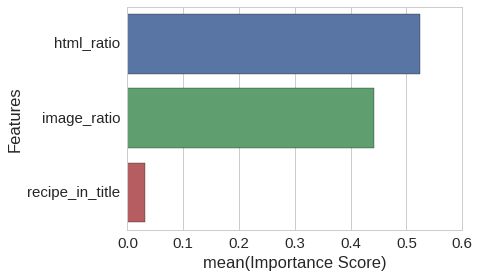

In [21]:
# Plot feature importances
feature_names = X.columns
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df)

# Part 3: Using `CountVectorizer`

### 3.1 Count Vectorizer Demo
Use `CountVectorizer` to generate vectorized text features.

Scikit-learn has many pre-processing utilities that simplify tasks required to convert text into features for a model.

These can be found in the sklearn.preprocessing.text package.

We will use the StumbleUpon dataset again to perform text classification.  This time, we will use the text content itself to predict whether a page is ‘evergreen’ or not.

**CountVectorizer**

- CountVectorizer converts a collection of text into a matrix of features.  
- Each row will be a sample (an article or piece of text) 
- Each column will be a text feature (usually a count or binary feature per word).

- CountVectorizer takes a column of text and creates a new dataset.  
- It generates a feature for every word in all of the pieces of text.

**REMEMBER:** Using all of the words can be useful, but we may need to use regularization to avoid overfitting.  Otherwise, rare words may cause the model to overfit and not generalize.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer
vectorizer = CountVectorizer()

In [23]:
corpus = ['This is the first document.',
          'This is the second second document.',
          'And the third one.',
          'Is this the first document?']

# Use `fit` to learn the vocabulary of the corpus
V = vectorizer.fit_transform(corpus)

In [24]:
# The dimensions of the vectorized matrix are
print "Dimensions of V:"
print V.shape

Dimensions of V:
(4, 9)


In [25]:
# Num. of rows = num of records in corpus
print "Records (documents/sentences) in Corpus:"
print len(corpus)

Records (documents/sentences) in Corpus:
4


In [26]:
# Num. of columns = num of features
print "Size (words) in Vocabulary:"
print len(vectorizer.vocabulary_)

Size (words) in Vocabulary:
9


In [27]:
# Get words in vocabulary
print vectorizer.vocabulary_

{u'and': 0, u'third': 7, u'this': 8, u'is': 3, u'one': 4, u'second': 5, u'the': 6, u'document': 1, u'first': 2}


In [28]:
vectorizer.transform(['This document is a completely new document.']).toarray()

array([[0, 2, 0, 1, 0, 0, 0, 0, 1]])

In [29]:
zip(vectorizer.get_feature_names(), 
    vectorizer.transform(['This document is a completely new document.']).toarray()[0])

[(u'and', 0),
 (u'document', 2),
 (u'first', 0),
 (u'is', 1),
 (u'one', 0),
 (u'second', 0),
 (u'the', 0),
 (u'third', 0),
 (u'this', 1)]

### 3.2 Generate Text Features for `data['title']` using Count Vectorizer
Use `CountVectorizer` to generate vectorized text features.

**There are several parameters to utilize in CountVectorizer and problems that they address**

**What if I want to consider sequences of words?**

ngram_range - a range of word phrases to use
(1,1) means use all single words
(1,2) means use all contiguous pairs of word
(1,3) means use all triples

**What if I want to get rid of common words?**

stop_words=’english’
Stop words are non-content words (e.g. ‘to’, ‘the’, ‘it’, etc).  They aren’t helpful for prediction, so they get removed.

**What if I think I'm over-fitting**?

max_features=1000
Maximum number of words to consider (uses the first N most frequent)

**What if I want to test for the presence of a word, but don't care about the count?**

binary=True

To use a dummy column as the entry (1 or 0, as opposed to the count).  This is useful if you think a word appearing 10 times is no more important than whether the word appears at all.

In [30]:
vectorizer = CountVectorizer(max_features = 1000,
                             ngram_range=(1, 2),
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(data['title'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['title'])

In [31]:
X_new_text_features[0:5,0:15].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [32]:
data.title[3]

u'10 Foolproof Tips for Better Sleep '

In [33]:
vectorizer.get_feature_names()

[u'000',
 u'10',
 u'10 best',
 u'10 things',
 u'10 ways',
 u'100',
 u'101',
 u'101 cookbooks',
 u'11',
 u'12',
 u'13',
 u'14',
 u'15',
 u'16',
 u'17',
 u'18',
 u'20',
 u'2007',
 u'2008',
 u'2008 sports',
 u'2009',
 u'2010',
 u'2010 sports',
 u'2011',
 u'2011 sports',
 u'2012',
 u'2013',
 u'2013 check',
 u'2013 sports',
 u'22',
 u'24',
 u'25',
 u'30',
 u'3d',
 u'50',
 u'8211',
 u'8217',
 u'8230',
 u'abs',
 u'accessories',
 u'actually',
 u'advice',
 u'air',
 u'alcohol',
 u'allrecipes',
 u'allrecipes com',
 u'almond',
 u'amazing',
 u'america',
 u'american',
 u'analysis',
 u'anderson',
 u'android',
 u'angeles',
 u'angeles slideshows',
 u'apple',
 u'apples',
 u'apps',
 u'archive',
 u'art',
 u'asian',
 u'athletes',
 u'atlantic',
 u'attack',
 u'avocado',
 u'awards',
 u'awesome',
 u'baby',
 u'bacon',
 u'bad',
 u'bake',
 u'baked',
 u'baked potatoes',
 u'baker',
 u'bakers',
 u'baking',
 u'ball',
 u'balls',
 u'balsamic',
 u'banana',
 u'banana bread',
 u'bar',
 u'bar refaeli',
 u'bars',
 u'basil',

**Vectorizers are like other models in scikit-learn.**

1. We create a vectorizer object with the parameters of our feature space.
2. We fit a vectorizer to learn the vocabulary.
3. We transform a set of text into that feature space.

**Note: there is a distinction between fit and transform.**

We fit from our training set.  This is part of the model building process, so we don’t look at our test set.

We transform our test set using our model fit on the training set.


In [34]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']

# Set target variable name
target = 'label'

# Get X
X_existing_features = data[existing_features]

In [35]:
# Set X and y
X = sp.sparse.hstack((X_new_text_features, X_existing_features)).toarray()
y = data[target]

Accuracy: 0.733
ROC AUC: 0.800


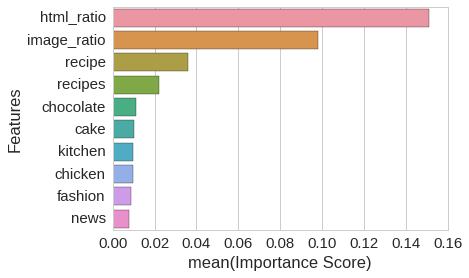

In [36]:
# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = vectorizer.get_feature_names() + existing_features
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df.head(10))

### 3.3 Generate Text Features for `data['body']` using Count Vectorizer
Use `CountVectorizer` to generate vectorized text feature for `data['body']`

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
# Create vectorized text feature matrix for data['body']

vectorizer = CountVectorizer(max_features = 1000,
                             ngram_range=(1, 2),
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the body text
vectorizer.fit(data['body'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['body'])

Accuracy: 0.783
ROC AUC: 0.830


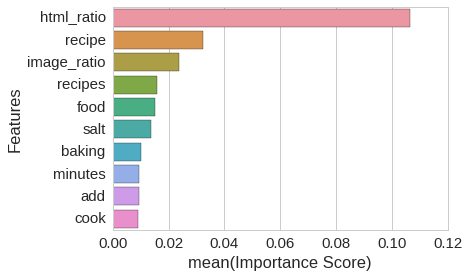

In [38]:
# Set features to use
existing_features = ['image_ratio', 'html_ratio']

# Set target variable name
target = 'label'

# Get X
X_existing_features = data[existing_features]

# Set X and y
X = sp.sparse.hstack((X_new_text_features, X_existing_features)).toarray()
y = data[target]


# Create separate training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

vectorizer = CountVectorizer(max_features = 1000,
                             ngram_range=(1, 2),
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the titles
vectorizer.fit(data['body'])

# Use `tranform` to generate the vectorized matrix
X_new_text_features = vectorizer.transform(data['body'])


# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])


# Plot feature importances
feature_names = vectorizer.get_feature_names() + existing_features
feature_importances = clf.feature_importances_
feature_dict = dict(zip(feature_names, feature_importances))

features_df = pd.DataFrame(feature_dict.items(), columns=['Features', 'Importance Score'])
features_df.sort_values('Importance Score', inplace=True, ascending=False)
sns.barplot(y='Features', x='Importance Score', data=features_df.head(10))

### COUNTVECTORIZER EXAMPLE

In [39]:
titles = data['title'].fillna('')

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features = 1000, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=True)

# Use `fit` to learn the vocabulary of the titles 
vectorizer.fit(titles)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(titles)

We can now build a random forest model to predict “evergreenness”.

In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)

# Use `fit` to learn the vocabulary of the titles 
vectorizer.fit(titles)

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X = vectorizer.transform(titles)
y = data['label']

from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

CV AUC [ 0.78937449  0.80483588  0.80660034], Average AUC 0.800270236236


**TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY**

An alternative bag-of-words approach to CountVectorizer is a **Term Frequency - Inverse Document Frequency (TF-IDF)** representation.

**TF-IDF** uses the product of two intermediate values, the **Term Frequency** and **Inverse Document Frequency**.

**TERM FREQUENCY**

Term Frequency is equivalent to CountVectorizer features, just the number of times a word appears in the document (i.e. count).

**INVERSE DOCUMENT FREQUENCY**

Document Frequency is the percentage of documents that a particular word appears in. 

For example, “the” would be 100% while “Syria” is much lower.  

Inverse Document Frequency is just 1/Document Frequency.

**Bringing them together**

Combining, TF-IDF = Term Frequency * Inverse Document Frequency or TF-IDF = Term Frequency / Document Frequency

The intuition is that the words that have high weight are those that either appear frequently in this document or appear rarely in other documents (and are therefore unique to this document).  

This is a good alternative to using a static set of “stop” words.

# Part 4: [Exercise] Using `TfidfVectorizer`

### 4.1 Generate Text Features for `data['body']` using TF-IDF Vectorizer
Use `TfidfVectorizer` to generate vectorized text features.
Does it perform better than `CountVectorizer`?

In [41]:
import scipy as sp
import numpy as np
import pandas as pd
import json
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import ensemble
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid", font_scale=1.5)
%matplotlib inline

# Load data
data = pd.read_csv("assets/dataset/stumbleupon.tsv", sep='\t')

# Split `boilerplate` column
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))

data = data.dropna()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
existing_features = ['image_ratio', 'html_ratio']
text_feature = ['body']
# Create vectorized text feature matrix for data['body']
X = data[existing_features + text_feature]
y = data['label']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=42)

# Keep non-text features separate
X_train_df = X_train[existing_features]
X_test_df = X_test[existing_features]

# Use `fit` to learn the vocabulary of the titles 
vectorizer.fit(X_train[text_feature[0]])

# Use `tranform` to generate the sample X word matrix - one column per feature (word or n-grams)
X_train_dtm = vectorizer.transform(X_train[text_feature[0]])
X_test_dtm = vectorizer.transform(X_test[text_feature[0]])

# Combine text and non-text features WARNING: overwrites X_train and X_test
X_train = sp.sparse.hstack((X_train_dtm, X_train_df))
X_test = sp.sparse.hstack((X_test_dtm, X_test_df))

# Build RF model using 'image_ratio', 'html_ratio', and TF-IDF vectorized features for 'body'
# Instantiate model
clf = ensemble.RandomForestClassifier(n_estimators=200)

# Train model on training set
clf.fit(X_train, y_train)


# Evaluate accuracy of model on test set
print "Accuracy: %0.3f" % clf.score(X_test, y_test)

# Evaluate ROC AUC score of model on test set
print 'ROC AUC: %0.3f' % metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

Accuracy: 0.782
ROC AUC: 0.825


# BREAK

# INDEPENDENT PRACTICE: TEXT CLASSIFICATION IN SCIKIT-LEARN
Objective: Demonstrate how to classify text or documents using scikit-learn

# ACTIVITY: TEXT CLASSIFICATION IN SCIKIT-LEARN

Use the text features of title with one or more feature sets from the previous random forest model. 
- Train this model to see if it improves AUC.
- Use the body text instead of the title.  Does this give an improvement?
- Use TfIdfVectorizer instead of CountVectorizer.  Does this give an improvement?

You may also want to try the naive bayes algorithm since it's a common starting point in text problems: http://scikit-learn.org/stable/modules/naive_bayes.html

Feel free to pull out to a sidebar conversation if you want more detail on how it works, just know that there are very few tunable parameters.

**Check:** Were you able to prepare a model that uses both quantitative features and text features?  Does this model improve the AUC?

# TOPIC REVIEW

- Natural language processing (NLP) is the task of pulling meaning and information from text.
- This typically involves many subproblems including tokenization, cleaning (stemming and lemmatization), and parsing.
- After we have structured our text, we can identify features for other tasks, including classification, summarization, and translation.
- In scikit-learn, we use vectorizers to create text features for classification, such as CountVectorizer and TfIdfVectorizer.

# UPCOMING WORK

Project: Final Project, Deliverable 2 is due September 12th
- https://github.com/ga-students/DS-DC-14/tree/master/projects/final-projects/02-experiment-writeup

# LESSON: NATURAL LANGUAGE PROCESSING AND TEXT CLASSIFICATION
EXIT TICKET 

DON’T FORGET TO FILL OUT YOUR EXIT TICKET

http://goo.gl/forms/gG5qAw9QljgkHC2q1